<a href="https://colab.research.google.com/github/olszewskip/Sign_Language/blob/master/playground_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ardamavi/Sign-Language-Digits-Dataset

https://www.kaggle.com/datamunge/sign-language-mnist


In [1]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
working_dir = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Sign_Language/")
github_trainval_data = os.path.join(working_dir, "data/ardamavi/Dataset")
github_test_data = os.path.join(working_dir, "data/ardamavi/Dataset_test")
model_checkpoints = os.path.join(working_dir, "models/tmp")
kaggle_dir = os.path.join(working_dir, "data/kaggle/sign-language-mnist")

In [5]:
os.listdir(github_trainval_data)

['6', '7', '5', '0', '8', '4', '1', '2', '3', '9']

In [0]:
# # one-time thing: make a separete directory for test-data
# os.mkdir(github_test_data)

In [7]:
total_count = 0
for class_ in os.listdir(github_trainval_data):
  from_dir = os.path.join(github_trainval_data, class_)
  whole_count = len(os.listdir(from_dir))
  total_count += whole_count
  print(f"class {class_}: {whole_count} photos")

print(f"{total_count} photos in total")

class 6: 188 photos
class 7: 178 photos
class 5: 188 photos
class 0: 180 photos
class 8: 191 photos
class 4: 183 photos
class 1: 180 photos
class 2: 185 photos
class 3: 185 photos
class 9: 180 photos
1838 photos in total


In [0]:
# # one-time thing: set a fraction of the data aside for testing
# test_fraction = 0.1

# for class_ in os.listdir(github_trainval_data):
#   from_dir = os.path.join(github_trainval_data, class_)
#   whole_count = len(os.listdir(from_dir))
#   to_dir = os.path.join(github_test_data, class_)
#   os.mkdir(to_dir)
#   for file in os.listdir(from_dir):
#     if np.random.rand() < test_fraction:
#       from_file = os.path.join(from_dir, file)
#       to_file = os.path.join(to_dir, file)
#       os.rename(from_file, to_file)
#   test_count = len(os.listdir(to_dir))
#   print(f"{class_}: {test_count/whole_count} fraction put aside")

In [0]:
IMG_DIM = 100
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE_EPOCHS = 5

### Create the data-generators that will:
* handle loading the data from disk (each class from separate sub-directory),
* handle train-validation split (from a single directory of sub-directories),
* resclae RGB values by 1/255,
* alternatively apply data augmentation

In [0]:
def prepare_data_gens(image_dim):

  trainval_gen = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.1/0.8)

  trainval_gen_augment = ImageDataGenerator(rescale=1/255,
                                            validation_split=0.1/0.8,
                                            rotation_range=30,
                                            height_shift_range=0.1,
                                            width_shift_range=0.1,
                                            brightness_range=(0.9, 1.1),
                                            zoom_range=0.1
                                           )

  test_gen = ImageDataGenerator(rescale=1/255)

  train_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen = trainval_gen.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')

  train_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      shuffle=True,
      class_mode='categorical',
      subset='training')

  val_gen_augment = trainval_gen_augment.flow_from_directory(
      github_trainval_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation')


  test_gen = trainval_gen.flow_from_directory(
      github_test_data,
      target_size = (image_dim, image_dim),
      batch_size=BATCH_SIZE,
      class_mode='categorical')
  
  return train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen

In [16]:
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(100)

Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


In [17]:
train_gen[0][0].shape

(64, 100, 100, 3)

A few random unaugmented images.

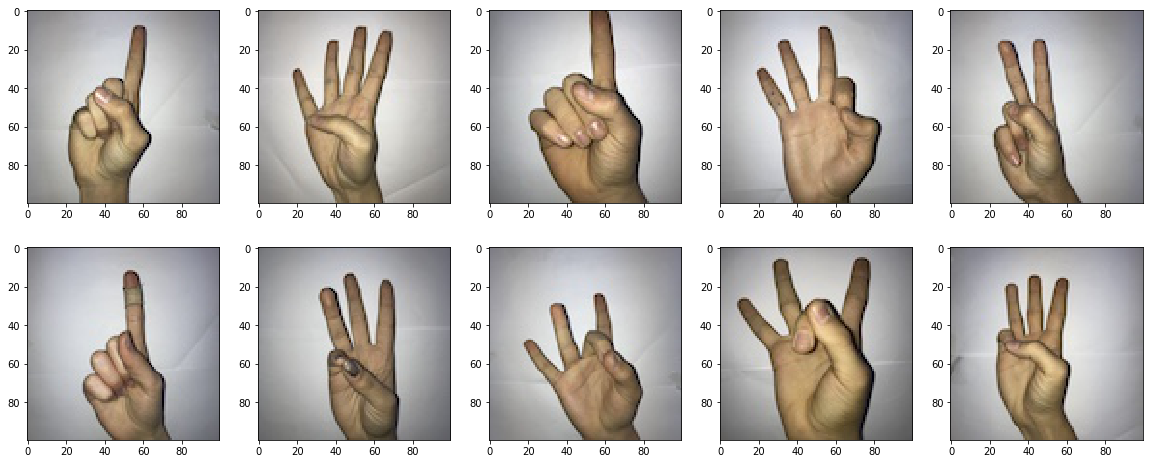

In [18]:
images\
= [train_gen[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(images, axes.ravel()):
  ax.imshow(img)

A few random augmented images.

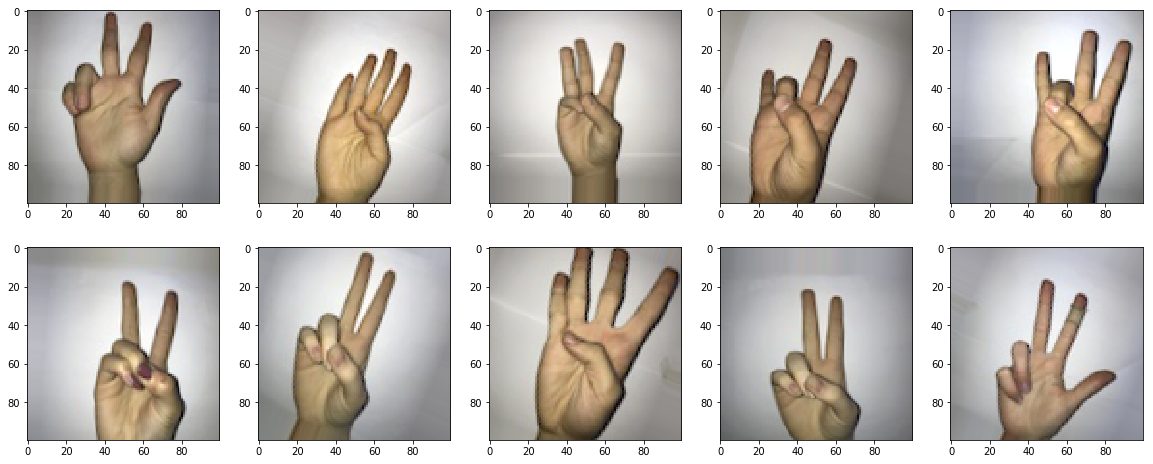

In [19]:
augmented_images\
= [train_gen_augment[0][0][np.random.choice(BATCH_SIZE)] for _ in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for img, ax in zip(augmented_images, axes.ravel()):
  ax.imshow(img)

In [20]:
# Sanity check that all generators see the same number of classes
assert train_gen.num_classes == val_gen.num_classes == train_gen_augment.num_classes == val_gen_augment.num_classes == test_gen.num_classes
num_classes = train_gen.num_classes

# Encoding between directory names and labels
label2class = train_gen.class_indices
label2class

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [0]:
def train_model(model, train_gen, val_gen, weights_file_name, verbosity=1):
  """ Fit the model to training-data-generator.
  Validate on validation-data-generator.
  Save weights of the best model to a file.
  Restore the best weights at the end of training.
  Return history for plotting"""
  
  train_gen.reset()
  val_gen.reset()
  callbacks = [ModelCheckpoint(filepath=os.path.join(model_checkpoints,
                                                     weights_file_name),
                               verbose=1,
                               save_best_only=True),
               EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=PATIENCE_EPOCHS,
                             verbose=1,
                             restore_best_weights=True)]

  history = model.fit_generator(
      train_gen,
      steps_per_epoch = int(np.ceil(train_gen.samples / BATCH_SIZE)),
      validation_data = val_gen,
      validation_steps = int(np.ceil(val_gen.samples / BATCH_SIZE)),
      epochs = EPOCHS,
      callbacks = callbacks,
      verbose=verbosity
  )
  return history



def plot_history(history):
  """Plot loss and accuracy on two separete plots."""
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  
  
def count_trainable(model):
  """Utility function"""
  return int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
 

---
## Simple sequential model

The number of trainable parameters is about 2 mil.

In [22]:
image_dim = 100
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 1613 images belonging to 10 classes.
Found 225 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


In [0]:
def simple_seq(img_dim):
  
  activ = 'elu'
  inputs = Input(shape = (img_dim, img_dim, 3))
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(inputs)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=activ)(x)
  x = MaxPooling2D((2,2))(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

### No data augmentation (simple seq.)

In [24]:
model1 = simple_seq(image_dim)

print("Trainable params:", count_trainable(model1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Trainable params: 2467946


Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 2.41982, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00002: val_loss improved from 2.41982 to 1.90942, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00003: val_loss improved from 1.90942 to 1.60790, saving model to /content/gdrive/My Drive/Colab Notebooks/Sign_Language/models/tmp/simple_seq_weights.h5

Epoch 00004: val_loss did not improve from 1.60790

Epoch 00005: val_loss did not improve from 1.60790

Epoch 00006: val_loss did not improve from 1.60790

Epoch 00007: val_loss did not improve from 1.60790

Epoch 00008: val_loss did not improve from 1.60790
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping


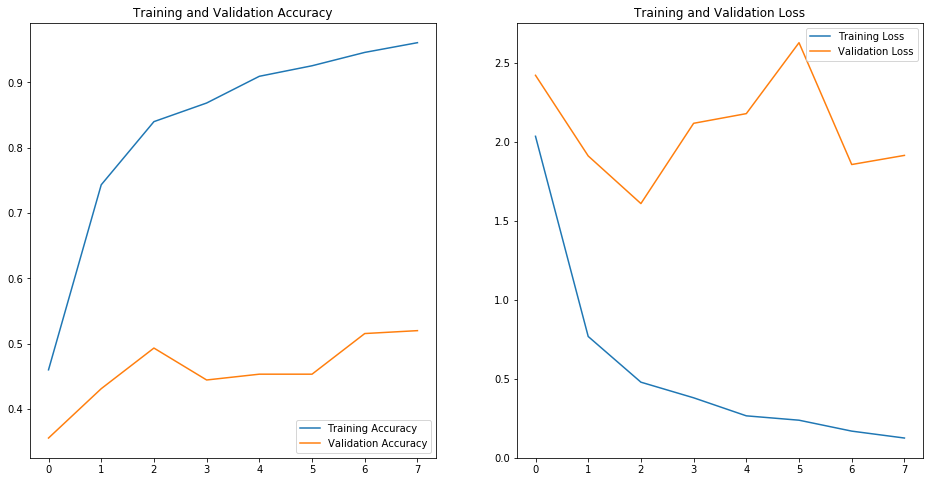

['loss', 'acc']


([1.6079031880696615, 0.49333333147896663],
 [0.5887981568064008, 0.8303571428571429])

In [25]:
LR_1 = 0.0004

model1.compile(loss = 'categorical_crossentropy',
               metrics=['accuracy'],
               optimizer = Adam(lr=LR_1))

history1 = train_model(model1,
                       train_gen,
                       val_gen,
                       "simple_seq_weights.h5",
                       0)

plot_history(history1)

val_gen.reset()

print(model1.metrics_names)

model1.evaluate_generator(val_gen,
                          steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
,\
model1.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

### With data augmentation (simple seq.)

*Note: The validation data is also augmented.*

In [0]:
model2 = simple_seq(image_dim)

print("Trainable params:", count_trainable(model2))

LR_2 = 0.0004

model2.compile(loss = 'categorical_crossentropy',
               metrics=['accuracy'],
               optimizer = Adam(lr=LR_2))

history2 = train_model(model2,
                       train_gen_augment,
                       val_gen_augment,
                       "simple_seq_with_augm_weights.h5",
                       0)

plot_history(history2)

val_gen_augment.reset()

print(model2.metrics_names)

model2.evaluate_generator(val_gen_augment,
                          steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE)))\
,\
model2.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

Trainable params: 2467946


---
## MobileNet_V2 - feature-extractor
Rather that coming up with out own architecture, let's use one that was developed by someone else: here we choose the MobileNet V2.
Check the performance both with and without retraining (some of) the weights (originally trainded on *image-net*).

In [0]:
def mobile_net_v2(img_dim, retrain):
  
  if retrain:
    MobileNetV2_ = MobileNetV2(include_top=False,
                               weights=None,
                               input_shape=(img_dim, img_dim, 3))
    layer_count = len(MobileNetV2.layers)
    for layer in MobileNetV2.layers[layer_count // 2 : ]:
      layer.trainable = True
  else:
    MobileNetV2_ = MobileNetV2(include_top=False,
                               weights='imagenet',
                               input_shape=(img_dim, img_dim, 3))
      
  x = MobileNetV2_.output
  x = GlobalMaxPooling2D()(x)
  x = Dropout(rate=0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=MobileNetV2_.input, outputs=output)
  return model

### No data augmentation, no mobilenet-retraining

In [0]:
image_dim = 128
train_gen, val_gen, train_gen_augment, val_gen_augment, test_gen = prepare_data_gens(image_dim)

In [0]:
model3 = mobile_net_v2(image_dim, retrain=False)

print("Trainable params:", count_trainable(model3))

In [0]:
LR_3 = 0.001

model3.compile(optimizer=Adam(lr=LR_3),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

train_gen.reset()
val_gen.reset()

history3 = train_model(model3, train_gen, val_gen, "mobilenetv2_weights.h5", 1)

plot_history(history3)

print(model3.metrics_names)

model3.evaluate_generator(val_gen,
                          steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
,\
model3.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

### With data augmentation, no mobilenet-retraining

*Note: The validation data is also augmented.*

In [0]:
image_dim = 128

model4 = mobile_net_v2(image_dim, retrain=False)

print("Trainable params:", count_trainable(model4))

In [0]:
LR_4 = 0.001

model4.compile(optimizer=Adam(lr=LR_4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

train_gen.reset()
val_gen.reset()

history4 = train_model(model4,
                       train_gen_augment,
                       val_gen_augment,
                       "mobilenetv2_with_augment_weights.h5",
                       0)

plot_history(history4)

print(model4.metrics_names)

model4.evaluate_generator(val_gen_augment,
                          steps = int(np.ceil(val_gen_augment.samples / BATCH_SIZE)))\
,\
model4.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

### Without data augmentation, with mobilenet-retraining

In [0]:
image_dim = 128

model5 = mobile_net_v2(image_dim, retrain=True)

In [0]:
LR_5 = 0.001

model5.compile(optimizer=Adam(lr=LR_5),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

train_gen.reset()
val_gen.reset()

history5 = train_model(model5,
                       train_gen,
                       val_gen,
                       "mobilenetv2_retrain_weights.h5",
                       0)

plot_history(history5)

print(model5.metrics_names)

model5.evaluate_generator(val_gen,
                          steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
,\
model5.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))

### With data augmentation, with mobilenet-retraining

*Note: The validation data is also augmented.*

In [0]:
image_dim = 128

model6 = mobile_net_v2(image_dim, retrain=True)

print("Trainable params:", count_trainable(model6))

In [0]:
LR_6 = 0.001

model6.compile(optimizer=Adam(lr=LR_6),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

train_gen.reset()
val_gen.reset()

history6 = train_model(model6,
                       train_gen_augment,
                       val_gen_augment,
                       "mobilenetv2_with_augment_retrain_weights.h5",
                       0)

plot_history(history6)

print(model6.metrics_names)

model6.evaluate_generator(val_gen_augment,
                          steps = int(np.ceil(val_gen.samples / BATCH_SIZE)))\
,\
model6.evaluate_generator(test_gen,
                          steps = int(np.ceil(test_gen.samples / BATCH_SIZE)))